In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from signal_utils_1D import *

sampling_indices = (3, 4)

## Make a random bandlimited signal and show it in pixel coordinates and intensity coordinates 

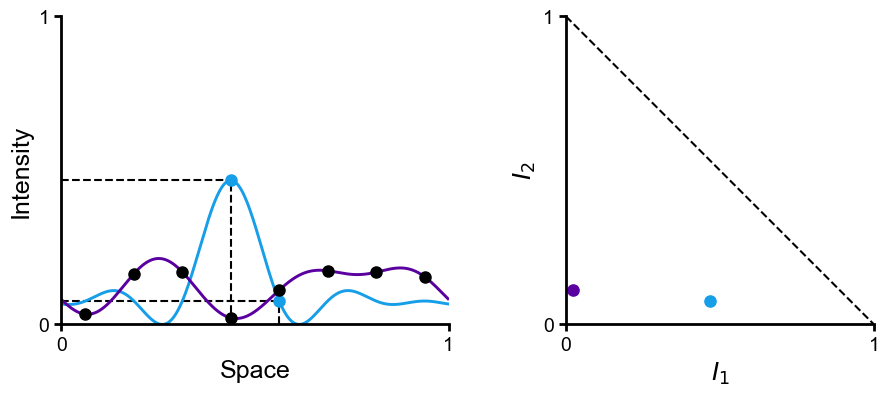

In [2]:
# plot a genrated signal and sample points
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

signal1 = generate_concentrated_signal(sampling_indices)
signal2 = bandlimited_nonnegative_signal(random_unnormalized_signal())

plot_in_spatial_coordinates(ax[0], signal1, sample_point_indices=sampling_indices,  color_samples=True,
                            vertical_line_indices=sampling_indices, horizontal_line_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], signal1, markersize=65)

plot_in_spatial_coordinates(ax[0], signal2)
plot_in_intensity_coordinates(ax[1], signal2, markersize=65)


## Plot many randomly generate signals

nonnegative number of signals 6387


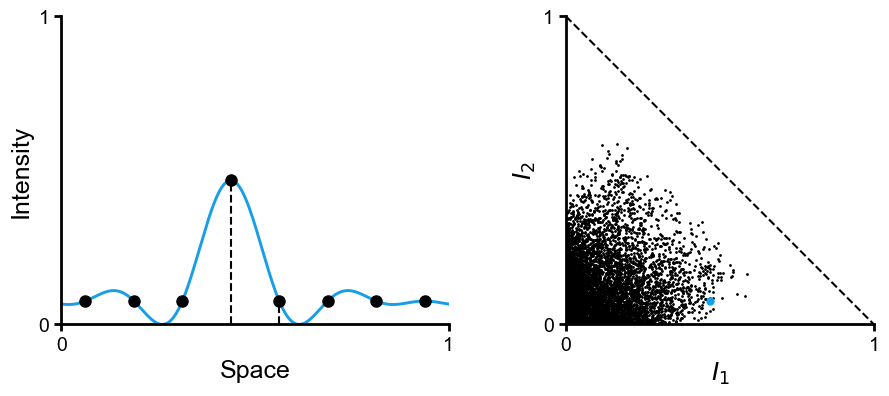

In [3]:
num_signals = 1000000

# plot a genrated signal and sample points
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
# plot a reference signal
concentrated_signal = generate_concentrated_signal(sampling_indices)
plot_in_spatial_coordinates(ax[0], concentrated_signal, vertical_line_indices=sampling_indices)


signals = onp.random.dirichlet(NUM_NYQUIST_SAMPLES * [0.25], size=num_signals)
mask = check_if_nonnegative(signals)
rejected_signals = signals[np.logical_not(mask)]
signals = signals[mask]
print('nonnegative number of signals', signals.shape[0])

# plot_in_intensity_coordinates(ax[1], rejected_signals, markersize=1)
plot_in_intensity_coordinates(ax[1], signals, markersize=1, color='k')
plot_in_intensity_coordinates(ax[1], concentrated_signal,  markersize=25)


## Test optimization of a signal

initial loss 0.47767872


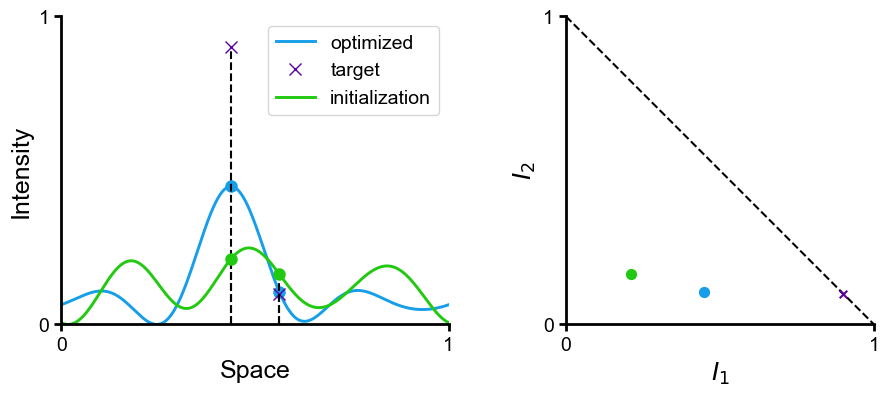

In [4]:

original_signal = bandlimited_nonnegative_signal(random_unnormalized_signal())
target_signal = onp.zeros_like(original_signal)
target_signal[sampling_indices[0]] = 0.9
target_signal[sampling_indices[1]] = 0.1
target_signal = np.array(target_signal)

# optimize signal values directly
# loss_fn = lambda signal: np.sum((signal[..., :2] - target_signal[..., :2])**2) 
# signal = run_optimzation(loss_fn, bandlimited_nonnegative_signal, 
#                 original_signal, learning_rate=1e0, verbose=True)

# optimize the real and imag coefficients


optimized_params = run_optimzation(make_real_imag_loss_fn(target_signal, indices=sampling_indices), real_imag_bandlimit_energy_norm_prox_fn, 
                np.concatenate(real_imag_params_from_signal(original_signal)), learning_rate=1e-2, verbose=True)
real, imag = optimized_params[:NUM_NYQUIST_SAMPLES // 2 + 1], optimized_params[NUM_NYQUIST_SAMPLES // 2 + 1:]
optimized_signal = signal_from_real_imag_params(real, imag)



fig, ax = plt.subplots(1, 2, figsize=(11, 4))




# plot the optimized signal
plot_in_spatial_coordinates(ax[0], optimized_signal,  label='optimized', sample_point_indices=sampling_indices, color_samples=True,)
                           
plot_in_intensity_coordinates(ax[1], optimized_signal, color=None, markersize=50, sample_point_indices=sampling_indices,)

# plot the target signal
plot_in_spatial_coordinates(ax[0], target_signal, label='target', show_upsampled=False, sample_point_indices=sampling_indices,
                             vertical_line_indices=sampling_indices, color_samples=True, marker='x')
plot_in_intensity_coordinates(ax[1], target_signal, marker='x',
                               sample_point_indices=sampling_indices)

# plot the original signal
plot_in_spatial_coordinates(ax[0], original_signal, label='initialization', sample_point_indices=sampling_indices, color_samples=True,
                             vertical_line_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], original_signal, markersize=50, sample_point_indices=sampling_indices)

ax[0].legend()

## Optimize signals to a grid of possibilities to figure out how they can be dispersed across intensity coordinates

100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


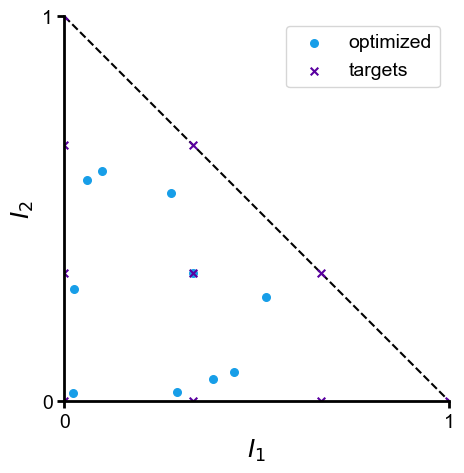

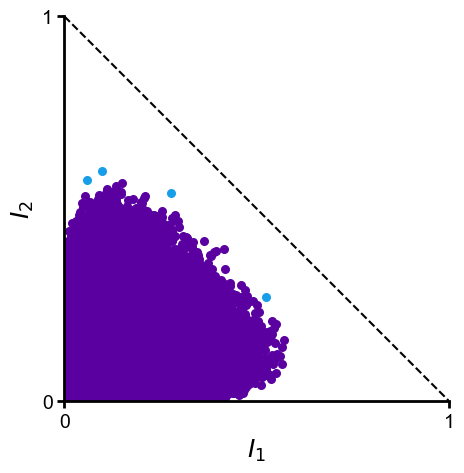

: 

In [6]:
target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=14)
original_signal = bandlimited_nonnegative_signal(random_unnormalized_signal())

optimized_signals = []
for target_signal in tqdm(target_signals):
    optimized_params = run_optimzation(make_real_imag_loss_fn(target_signal, indices=sampling_indices), real_imag_bandlimit_energy_norm_prox_fn, 
                    np.concatenate(real_imag_params_from_signal(original_signal)), learning_rate=1e-3, verbose=False)
    optimized_signals.append(signal_from_real_imag_params(*param_vector_to_real_imag(optimized_params)))
optimized_signals = np.array(optimized_signals)


# make plots
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_in_intensity_coordinates(ax, optimized_signals, label='optimized')
plot_in_intensity_coordinates(ax, target_signals, marker='x', label='targets')
ax.legend()
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'optmized_bandlimited_signals' + '.pdf', transparent=True)

# compare to some random samples
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_in_intensity_coordinates(ax, optimized_signals, label='optimized')

signals = onp.random.dirichlet(NUM_NYQUIST_SAMPLES * [1], size=num_signals)
mask = check_if_nonnegative(signals)
signals = signals[mask]

# plot_in_intensity_coordinates(ax[1], rejected_signals, markersize=1)
plot_in_intensity_coordinates(ax, signals)

